# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Dell\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('../amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'only', 'by', 'under', 'while', "couldn't", 'me', 'herself', 'yourselves', 'a', 'until', 'both', 'does', 'on', 'she', 'myself', 'having', 'most', "mustn't", 'hasn', 'was', 'as', "aren't", 'should', "you'd", 'these', 'so', 'between', 'no', 'it', 'how', 'have', 'did', 'can', 'my', 'your', 'we', "you'll", 'him', 'too', 'its', "didn't", 'very', 'more', 'you', 'm', 'hers', 'why', 'again', 'for', 'in', 'there', 'y', 'the', "hadn't", 'at', 'didn', "shan't", 'our', "wouldn't", 'what', 'when', 'doesn', 'yourself', 'but', 'of', 'during', 'all', 'hadn', 'theirs', 'don', 'himself', 'those', 'further', 'ourselves', "you've", "she's", 'before', 'same', 'ma', 'will', 're', 've', 'his', 'shan', 'themselves', 't', 'needn', 'yours', 'doing', 'are', 'being', 'each', 'd', 'them', 'above', 'and', 'wasn', 'here', 'any', 'into', "won't", "wasn't", 'mustn', 'up', "shouldn't", 'from', 'had', 'which', 'do', 'about', 'mightn', "isn't", 'shouldn', 'just', 'isn', 'out', 'or', 'been', 'couldn', 'were', 'this', 'th

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
#if not os.path.isfile('final.sqlite'):
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1

#############---- storing the data into .sqlite file ------########################
#final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
#final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
#conn = sqlite3.connect('final.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
           #  index=True, index_label=None, chunksize=None, dtype=None)
#conn.close()


#with open('positive_words.pkl', 'wb') as f:
  #  pickle.dump(all_positive_words, f)
#with open('negitive_words.pkl', 'wb') as f:
  #  pickle.dump(all_negative_words, f)

100%|████████████████████████████████████| 364171/364171 [11:04<00:00, 548.13it/s]


In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
# Getting Equal Positive and Negative Reviews
final_positive=final[final['Score']=='positive'][0:50000]
final_negative=final[final['Score']=='negative'][0:50000]

In [15]:
# Joining the Reviews
final_np=pd.concat([final_positive,final_negative])
final_np.shape

(100000, 11)

In [16]:
final_np=final.head(100000)

In [17]:
final_np['Score'].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

In [18]:
# Sorting data based on time
final_np["Time"] = pd.to_datetime(final_np["Time"], unit = "s")
final_np = final_np.sort_values(by = "Time")

In [19]:
final_np.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# Optimal Parameters from GridSearchCV and RandomizedSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

def svm_grid(X_train,y_train):
    clf = SGDClassifier(loss='hinge', class_weight='balanced')
    #params we need to try on classifier
    param_dist = {'alpha':[10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]} 
    gscv = GridSearchCV(clf,param_dist,cv=tscv,verbose=1,scoring='f1_micro',n_jobs=-1)
    gscv_fit=gscv.fit(X_train,y_train)
    # Plotting HyperParameter Graph
    m_t_s=[i for i in gscv.cv_results_['mean_test_score']]
    al=[i for i in gscv.cv_results_['param_alpha']]
    plt.xlabel("alpha")
    plt.ylabel("Accuracy Score")
    plt.title('Accuracy v/s alpha')
    plt.plot(al,m_t_s,'b')
    plt.show()
    print(pd.DataFrame(gscv_fit.cv_results_).sort_values('mean_test_score', ascending=False).head())
    print('Best alpha(1/C):', gscv_fit.best_estimator_.get_params()['alpha'])
    print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))
    

In [21]:
def confusion_matrix_np(cm):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [22]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

# [7.2.2] Bag of Words (BoW)

In [23]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [24]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [26]:
#BoW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train=count_vect.fit_transform(X_train)

In [27]:
X_test=count_vect.transform(X_test)

# GridSearchCV

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.6s finished


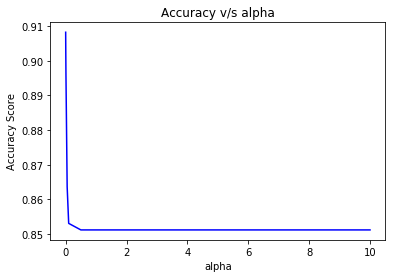

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
8       0.320816      0.113066         0.061765        0.010022       0.001   
7       0.302726      0.126555         0.059666        0.009073       0.005   
6       0.400870      0.241470         0.065663        0.016003        0.01   
5       0.368388      0.193100         0.064063        0.012374        0.05   
4       0.317618      0.143003         0.055968        0.010152         0.1   

             params  split0_test_score  split1_test_score  split2_test_score  \
8  {'alpha': 0.001}           0.891403           0.899261           0.907119   
7  {'alpha': 0.005}           0.894075           0.899261           0.901933   
6   {'alpha': 0.01}           0.891875           0.894389           0.900204   
5   {'alpha': 0.05}           0.862643           0.861386           0.860758   
4    {'alpha': 0.1}           0.851485           0.847556           0.848656   

   split3_test_score       ...         split

In [28]:
#SVMGrid
svm_bow= svm_grid(X_train, y_train)
svm_bow

In [29]:
svm = SGDClassifier(loss='hinge',alpha=0.001,,class_weight='balanced')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

In [30]:
# Accuracy on train data
train_acc_bow = svm.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)


Train Accuracy 92.57714285714286


In [31]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  91.59


In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[ 2372,  2015],
       [  508, 25105]], dtype=int64)

In [33]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.82      0.54      0.65      4387
   positive       0.93      0.98      0.95     25613

avg / total       0.91      0.92      0.91     30000



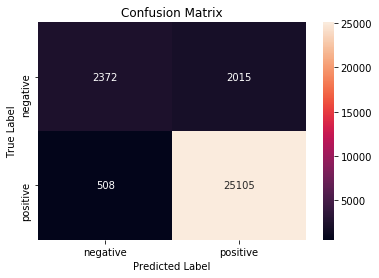

In [34]:
confusion_matrix_np(cm)

In [35]:
show_most_informative_features(count_vect,svm)

			Negative						Positive
________________________________________________________________________________________________
	-0.9795	worst          				0.5597	delici         
	-0.8481	disappoint     				0.5540	amaz           
	-0.8396	terribl        				0.5340	great          
	-0.7710	aw             				0.5312	excel          
	-0.7653	return         				0.4940	best           
	-0.7482	horribl        				0.4855	awesom         
	-0.6939	threw          				0.4683	perfect        
	-0.6340	wors           				0.4455	addict         
	-0.6340	stale          				0.4169	satisfi        
	-0.6111	refund         				0.4141	nice           
	-0.6026	bland          				0.3998	happi          
	-0.5997	tasteless      				0.3969	yummi          
	-0.5911	unfortun       				0.3827	beat           
	-0.5740	money          				0.3827	smooth         
	-0.5683	disgust        				0.3770	love           
	-0.5569	poor           				0.3513	fantast        
	-0.5340	sorri          				0.3484	glad           
	-0.5254	g

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [36]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [37]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [38]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [40]:
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
X_train = count_vect.fit_transform(X_train)
X_test=count_vect.transform(X_test)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   47.8s finished


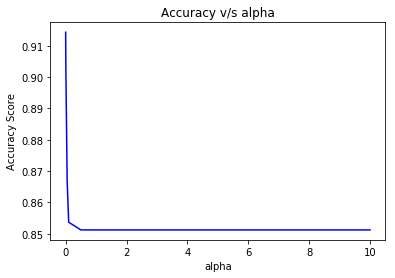

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
8       1.162434      0.347244         0.084352        0.016796       0.001   
7       1.251083      0.457504         0.084252        0.015885       0.005   
6       1.241289      0.409740         0.076556        0.009195        0.01   
5       1.293059      0.419141         0.076057        0.012260        0.05   
4       1.341932      0.460071         0.078555        0.013682         0.1   

             params  split0_test_score  split1_test_score  split2_test_score  \
8  {'alpha': 0.001}           0.899419           0.902876           0.906805   
7  {'alpha': 0.005}           0.897690           0.899733           0.903505   
6   {'alpha': 0.01}           0.896747           0.894704           0.901304   
5   {'alpha': 0.05}           0.868144           0.863586           0.862015   
4    {'alpha': 0.1}           0.852114           0.847556           0.848971   

   split3_test_score       ...         split

In [41]:
#SVMGrid
svm_bow= svm_grid(X_train, y_train)
svm_bow

In [42]:
svm = SGDClassifier(loss='hinge',alpha=0.001,class_weight='balanced')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)


In [43]:
# Accuracy on train data
train_acc_bow = svm.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 95.72428571428571


In [44]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  92.35666666666667


In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2525,  1862],
       [  431, 25182]], dtype=int64)

In [46]:
# Classification report
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

   negative       0.85      0.58      0.69      4387
   positive       0.93      0.98      0.96     25613

avg / total       0.92      0.92      0.92     30000



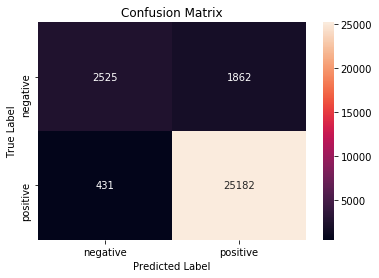

In [47]:
confusion_matrix_np(cm)

In [48]:
show_most_informative_features(count_vect,svm)

			Negative						Positive
________________________________________________________________________________________________
	-0.8253	worst          				0.5254	delici         
	-0.7882	disappoint     				0.5055	high recommend 
	-0.6797	terribl        				0.4997	wont disappoint
	-0.6568	horribl        				0.4598	excel          
	-0.6111	return         				0.4512	amaz           
	-0.6083	aw             				0.4483	best           
	-0.5740	stale          				0.4369	perfect        
	-0.5597	threw          				0.4169	awesom         
	-0.5197	bland          				0.3884	nice           
	-0.5026	wors           				0.3855	great          
	-0.5026	refund         				0.3741	yummi          
	-0.4997	tasteless      				0.3684	addict         
	-0.4912	wont buy       				0.3398	fantast        
	-0.4855	mislead        				0.3398	satisfi        
	-0.4855	disgust        				0.3313	never disappoint
	-0.4655	money          				0.3313	smooth         
	-0.4655	unfortun       				0.3284	love           
	-0.4398	

# [7.2.5] TF-IDF

In [49]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)


shape of X: (100000,)


In [50]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [52]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_test = tf_idf_vect.transform(X_test)


# GridSearchCV

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.8s finished


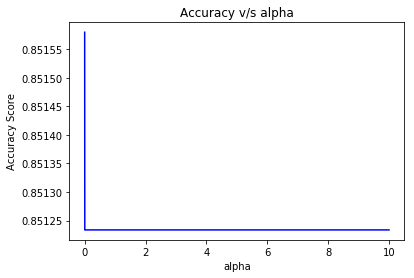

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
8       0.242362      0.102726         0.060465        0.008353       0.001   
0       0.232366      0.105133         0.056867        0.009968          10   
1       0.246659      0.112291         0.057867        0.008521           5   
2       0.252755      0.113788         0.053669        0.004689           1   
3       0.235965      0.106645         0.057467        0.008305         0.5   

             params  split0_test_score  split1_test_score  split2_test_score  \
8  {'alpha': 0.001}           0.848656           0.845985           0.845985   
0     {'alpha': 10}           0.847399           0.845513           0.845670   
1      {'alpha': 5}           0.847399           0.845513           0.845670   
2      {'alpha': 1}           0.847399           0.845513           0.845670   
3    {'alpha': 0.5}           0.847399           0.845513           0.845670   

   split3_test_score       ...         split

In [53]:
#SVMGrid
svm_tfidf= svm_grid(X_train, y_train)
svm_tfidf

In [54]:
svm = SGDClassifier(loss='hinge',alpha=0.001,class_weight='balanced')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

In [55]:
# Accuracy on train data
train_acc_tfidf = svm.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 85.13571428571429


In [56]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  85.38


In [57]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[    1,  4386],
       [    0, 25613]], dtype=int64)

In [58]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       1.00      0.00      0.00      4387
   positive       0.85      1.00      0.92     25613

avg / total       0.88      0.85      0.79     30000



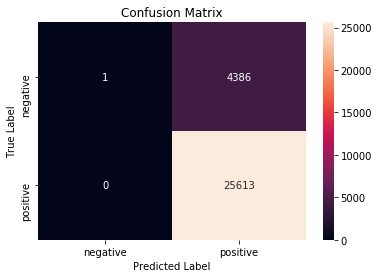

In [59]:
confusion_matrix_np(cm)


In [60]:
show_most_informative_features(tf_idf_vect,svm)

			Negative						Positive
________________________________________________________________________________________________
	-0.9202	disappoint     				0.6574	great          
	-0.8656	wast           				0.5416	love           
	-0.8566	return         				0.5242	best           
	-0.7496	terribl        				0.4050	delici         
	-0.7302	worst          				0.3871	good           
	-0.7041	horribl        				0.3616	excel          
	-0.6999	aw             				0.3368	perfect        
	-0.6824	threw          				0.3166	nice           
	-0.6722	money          				0.2890	find           
	-0.6370	refund         				0.2808	amaz           
	-0.5306	stale          				0.2447	wonder         
	-0.4265	disgust        				0.2382	favorit        
	-0.3701	bad            				0.2355	happi          
	-0.3568	bland          				0.2333	satisfi        
	-0.3539	gross          				0.2332	awesom         
	-0.3453	wors           				0.2318	easi           
	-0.3446	away           				0.2286	tasti          
	-0.3443	p

# [7.2.6] Word2Vec

In [105]:
from gensim.models import Word2Vec

In [106]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)


shape of X: (100000,)


In [107]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


# [7.2.7] Avg W2V

In [109]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
w2v_dim=300    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=w2v_dim, workers=4)

w2v_words = list(w2v_model.wv.vocab)

In [110]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

X_train = train_vectors
X_test = test_vectors

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.8min finished


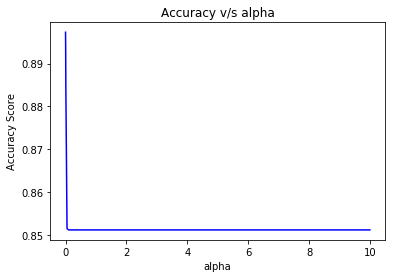

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
8       0.393174      0.176942         0.085850        0.019688       0.001   
7       0.470331      0.192709         0.103741        0.029223       0.005   
6       0.447643      0.220580         0.102142        0.020651        0.01   
5       0.421859      0.230758         0.085751        0.012742        0.05   
0       0.514805      0.251580         0.221873        0.334200          10   

             params  split0_test_score  split1_test_score  split2_test_score  \
8  {'alpha': 0.001}           0.883545           0.891089           0.893289   
7  {'alpha': 0.005}           0.886689           0.888103           0.893446   
6   {'alpha': 0.01}           0.887474           0.878045           0.881817   
5   {'alpha': 0.05}           0.847871           0.845670           0.845985   
0     {'alpha': 10}           0.847399           0.845513           0.845670   

   split3_test_score       ...         split

In [111]:
#SVMGrid
svm_avgw2v= svm_grid(X_train, y_train)
svm_avgw2v

In [112]:
svm = SGDClassifier(loss='hinge',alpha=0.001,class_weight='balanced')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

In [113]:
# Accuracy on train data
train_acc_avgw2v = svm.score(X_train, y_train)
print("Train Accuracy", train_acc_avgw2v*100)


Train Accuracy 89.75857142857143


In [114]:
# Accuracy on test data
test_acc_avgw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_avgw2v)

Test Accuracy  89.74333333333333


In [115]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 1732,  2655],
       [  422, 25191]], dtype=int64)

In [116]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.80      0.39      0.53      4387
   positive       0.90      0.98      0.94     25613

avg / total       0.89      0.90      0.88     30000



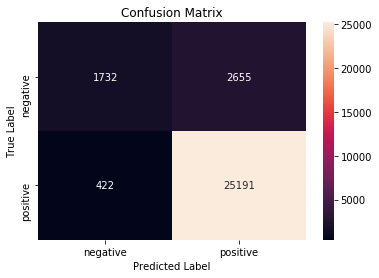

In [117]:
confusion_matrix_np(cm)


# TFIDF-W2V

In [118]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [119]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [121]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [123]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [124]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test

# GridSearchCV

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.6min finished


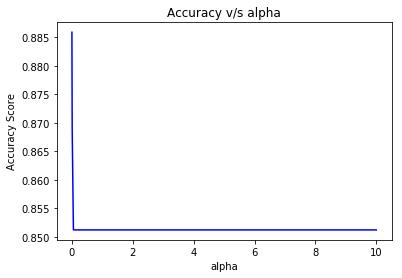

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
8       0.446744      0.222717         0.108039        0.032300       0.001   
7       0.730181      0.567746         0.133624        0.054957       0.005   
6       0.526298      0.239623         0.110938        0.022640        0.01   
5       0.505810      0.269625         0.104341        0.020860        0.05   
0       1.022849      0.822721         0.376504        0.580079          10   

             params  split0_test_score  split1_test_score  split2_test_score  \
8  {'alpha': 0.001}           0.871601           0.878202           0.883074   
7  {'alpha': 0.005}           0.877573           0.875530           0.873645   
6   {'alpha': 0.01}           0.864529           0.865787           0.864215   
5   {'alpha': 0.05}           0.847399           0.845670           0.845670   
0     {'alpha': 10}           0.847399           0.845513           0.845670   

   split3_test_score       ...         split

In [125]:
#SVMGrid
lrg_tfidfw2v= svm_grid(X_train, y_train)
lrg_tfidfw2v


In [126]:
svm = SGDClassifier(loss='hinge',alpha=0.001)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

In [127]:
# Accuracy on train data
train_acc_tfidfw2v = svm.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidfw2v*100)

Train Accuracy 88.50142857142858


In [128]:
# Accuracy on test data
test_acc_tfidfw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidfw2v)

Test Accuracy  88.61666666666666


In [129]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[ 1368,  3019],
       [  396, 25217]], dtype=int64)

In [130]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.78      0.31      0.44      4387
   positive       0.89      0.98      0.94     25613

avg / total       0.88      0.89      0.86     30000



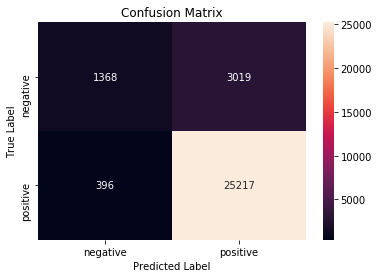

In [131]:
confusion_matrix_np(cm)

# Conclusion
* Bigram Vectorizer performs well with test accuracy equal to 92.35% and f1-score 0.92.

In [133]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer","CV","Alpha(1/C)","Train Accuracy","Test Accuracy","F-1 Score"]

x.add_row(["Unigram BOW", "GridSearchCV",0.001,92.57,91.59,0.91])
x.add_row(["Bigram BOW", "GridSearchCV",0.001,95.72,92.35,0.92])
x.add_row(["TF-IDF", "GridSearchCV",0.001,85.13,85.38,0.79])
x.add_row(["AVG-W2V", "GridSearchCV",0.001,89.75,89.74,0.88])
x.add_row(["TFIDF-W2V", "GridSearchCV",0.001,88.5,88.41,0.86])          

print("Performance Table")
print(x)

Performance Table
+-------------+--------------+------------+----------------+---------------+-----------+
|  Vectorizer |      CV      | Alpha(1/C) | Train Accuracy | Test Accuracy | F-1 Score |
+-------------+--------------+------------+----------------+---------------+-----------+
| Unigram BOW | GridSearchCV |   0.001    |     92.57      |     91.59     |    0.91   |
|  Bigram BOW | GridSearchCV |   0.001    |     95.72      |     92.35     |    0.92   |
|    TF-IDF   | GridSearchCV |   0.001    |     85.13      |     85.38     |    0.79   |
|   AVG-W2V   | GridSearchCV |   0.001    |     89.75      |     89.74     |    0.88   |
|  TFIDF-W2V  | GridSearchCV |   0.001    |      88.5      |     88.41     |    0.86   |
+-------------+--------------+------------+----------------+---------------+-----------+
